In [37]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np
import random

In [38]:
data = load_breast_cancer()
shuffledIndices = np.random.permutation(len(data.target))
data.data, data.target = data.data[shuffledIndices], data.target[shuffledIndices]
train_x, test_x = data.data[:100, 0:2], data.data[100:, 0:2]
train_y, test_y = data.target[:100], data.target[100:]

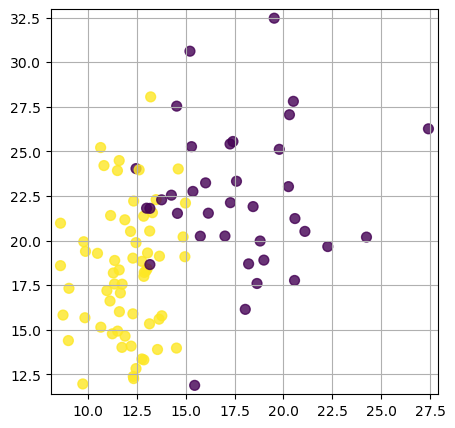

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(x=train_x[:, 0], y=train_x[:, 1], s=50, alpha=0.8, c=train_y)
plt.xlim(train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 0.5)
plt.ylim(train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 0.5)
plt.grid()
plt.show()

In [40]:
def sigmoid(x: np.array, e=2.7182) -> np.array: return 1 / (1 + e ** (-x))
def reLu(x: np.array) -> np.array: return np.array([max(0, value) for value in x])
def seLu(x: np.array, e=2.7182, a=1.0507) -> np.array: return np.array([value if value >= 0 else a * (e ** value - 1) for value in x])

In [41]:
def gdr(x, y, weight, act_func, lr: float):
    indications = act_func(np.dot(x, weight))
    weight -= (lr / x.shape[0]) * np.dot(x.T, (indications - y))
# gdr

class LogisticRegression:
    def __init__(self, shape): self.weight = np.random.rand(shape)
    def train(self, x, y, iters: int, lr=0.001):
        for epoch in range(iters): gdr(x, y, self.weight, sigmoid, lr)
    # train
    
    def __call__(self, x): return 1 if np.dot(x, self.weight) >= 0.5 else 0
    
    def loss(self, x, y):
        probability = np.dot(x, self.weight)
        loss = np.mean(np.exp(1 - probability) * y) + np.sum(np.exp(probability) * (1 - y))
        print(f"cost: {loss:.3f}")
    # loss
# LogisticRegression

In [42]:
lr = 0.0001
iters = 10000

In [43]:
model = LogisticRegression(train_x.shape[1])
model.loss(test_x, test_y)
model.train(train_x, train_y, iters=1000)

cost: 902029968.851


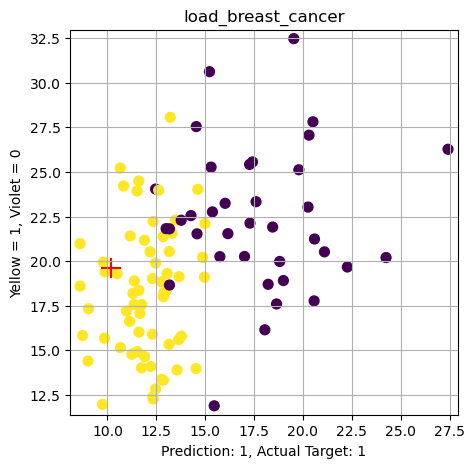

In [44]:
index = random.randrange(len(test_y))
prediction = model(test_x[index, :])

plt.figure(figsize=(5,5))
plt.scatter(x=train_x[:, 0], y=train_x[:, 1], s=50, alpha=1, c=train_y)
plt.scatter(x=test_x[index,0], y=test_x[index,1], c='r', s=200, marker='+')
plt.xlim(train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 0.5)
plt.ylim(train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 0.5)
plt.grid()
plt.xlabel(f"Prediction: {prediction:.0f}, Actual Target: {test_y[index]}")
plt.ylabel("Yellow = 1, Violet = 0")
plt.title("load_breast_cancer")
plt.show()

In [45]:
model.loss(test_x, test_y)

cost: 211.181
